# Annotated Graphs

Make a graph for annotated data. The annoted data sets do not include time mete data so these need to be extracted of the json files.

See also the notebook annotation-graphs, which provides a more efficient implementation for hour-level time retrieval.

## Read annotated data

In [232]:
import pandas as pd

In [330]:
TOPIC = "distance"

if TOPIC == "distance":
    DATA_FILE = f"../{TOPIC}-tweets.csv"
elif TOPIC == "mondkapje":
    DATA_FILE = f"{TOPIC}-202003-202103-1000.csv"
elif TOPIC == "testing":
    DATA_FILE = f"{TOPIC}-202003-202012.csv"
elif TOPIC == "vaccin":
    DATA_FILE = f"{TOPIC}-202001-202101-1000.csv"
DATA_DIR = "../data/annotation/"
LABEL_FILE = DATA_FILE + ".human-labels.txt"

In [333]:
label_data_raw

,0,1,2,3,4
0,erikt@xs4all.nl,20200714143955,1255811493528027142,0,ONEENS
1,erikt@xs4all.nl,20200714144029,1268107342220005377,2,EENS
2,erikt@xs4all.nl,20200714144052,1267584204696702980,4,EENS
3,erikt@xs4all.nl,20200714144052,1267715572822937606,5,EENS
4,erikt@xs4all.nl,20200714144128,1227669121673965580,9,ANDERS
...,...,...,...,...,...
7281,n.k.breedveld@uu.nl,20200802142246,1259888385663041547,997,ANDERS
7282,n.k.breedveld@uu.nl,20200802142255,1267545781017419776,998,ONEENS
7283,n.k.breedveld@uu.nl,20200802142306,1264072298321059840,999,ANDERS
7284,n.k.breedveld@uu.nl,20200802142309,1264072298321059840,999,EENS


In [334]:
data = pd.read_csv(DATA_DIR + DATA_FILE)
data.sort_values(by=['id_str'])
label_data_raw = pd.read_csv(DATA_DIR + LABEL_FILE, header=None, sep=" ")
label_data_raw.sort_values(by=[2])

label_data = {}
for row in label_data_raw.iterrows():
    annotator = row[1][0]
    id_str = row[1][2]
    label = row[1][4]
    if annotator == "erikt@xs4all.nl":
        label_data[id_str] = label

In [335]:
len(data), len(label_data)

(6835, 5977)

## Get time meta data

In [336]:
import gzip
import json
import os
from IPython.display import clear_output

In [337]:
JSON_DIR = "/home/erikt/media/20190525/files/cloud/twitter/2020"
FIRST_TWEET_IDS_FILE = "csv/first_tweet_ids.csv"

In [338]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [339]:
if False:
    first_tweet_ids = {}
    for month in range(1, 3+1):
        squeal(month)
        month_dir = JSON_DIR + str(month).zfill(2) + "/"
        file_names = sorted(os.listdir(month_dir))
        for file_name in file_names:
            infile = gzip.open(month_dir + file_name)
            line = infile.readline()
            infile.close()
            json_data = json.loads(line)
            first_tweet_ids[month_dir + file_name] = json_data['id_str']

In [340]:
if False:
    pd.DataFrame([{"file_name": file_name, "id_str": first_tweet_ids[file_name]} for file_name in first_tweet_ids]).to_csv(FIRST_TWEET_IDS_FILE, index=False)

In [341]:
first_tweet_ids = pd.read_csv(FIRST_TWEET_IDS_FILE).to_dict('records')

In [ ]:
first_tweet_ids_pointer = 0
time_data = {}
for row in data.iterrows():
    id_str = row[1]['id_str']
    if id_str in label_data.keys() and label_data[id_str] != "ANDERS":
        while first_tweet_ids[first_tweet_ids_pointer+1]['id_str'] < id_str and first_tweet_ids_pointer < len(first_tweet_ids)-1:
            first_tweet_ids_pointer += 1
        while first_tweet_ids[first_tweet_ids_pointer]['id_str'] > id_str and first_tweet_ids_pointer > 0:
            first_tweet_ids_pointer -= 1
        infile = gzip.open(first_tweet_ids[first_tweet_ids_pointer]['file_name'])
        for line in infile:
            json_data = json.loads(line)
            if json_data['id_str'] == str(id_str):
                time_data[json_data['id_str']] = json_data['created_at']
                squeal(json_data['created_at'])
        infile.close()

Sun Apr 19 10:09:01 +0000 2020


In [289]:
pd.DataFrame([{'id_str': id_str, 'created_at': time_data[id_str]} for id_str in time_data]).to_csv("csv/time_data."+DATA_FILE, index=False)

## Make graph

In [290]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [319]:
TIME_FILE = "csv/time_data." + DATA_FILE

In [320]:
label_data = pd.read_csv(DATA_DIR + LABEL_FILE, header=None, sep=" ")
time_data = pd.read_csv(TIME_FILE, index_col="id_str")

In [321]:
def make_graph_data_list(label_data, time_data):
    graph_data_dict = {}
    for row in label_data.iterrows():
        label = row[1][4]
        id_str = row[1][2]
        if label == "EENS" or label == "ONEENS":
            if id_str in time_data.index:
                graph_data_dict[id_str] = { "label": label, "created_at": time_data.loc[id_str]['created_at'] }
        elif label == "ANDERS":
            if id_str in graph_data_dict:
                del(graph_data_dict[id_str])
        else:
            print(f"make_graph_data: cannot happen: {label}")
    return([{'label': graph_data_dict[id_str]['label'], 'created_at': graph_data_dict[id_str]['created_at']} for id_str in sorted(graph_data_dict.keys())])

In [326]:
N = 100


def percentage(window):
    total_count = 0
    support_count = 0
    for row in window:
        total_count += 1
        if row['label'] == "EENS":
            support_count += 1
    return(100 * support_count / total_count)


def select_graph_data(graph_data_list):
    window = []
    x = []
    y = []
    for i in range(0, len(graph_data_list)):
        window.append(graph_data_list[i])
        if len(window) >= N:
            selected_time_index = int((N-1)*(i-N+1)/(len(graph_data_list)-N+1))
            x.append(datetime.datetime.strptime(window[selected_time_index]['created_at'], "%a %b %d %H:%M:%S %z %Y"))
            y.append(percentage(window))
        while len(window) >= N:
            window.pop(0)
    return(x, y)

In [327]:
graph_data_list = make_graph_data_list(label_data, time_data)

In [328]:
x, y = select_graph_data(graph_data_list)

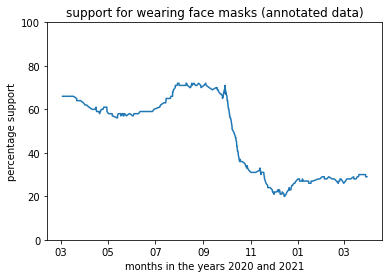

In [329]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.plot_date(x, y, fmt="-")
plt.ylim(0, 100)
plt.xlabel("months in the years 2020 and 2021")
plt.ylabel("percentage support")
plt.title(f"support for wearing face masks (annotated data)")
plt.savefig(f"annotated-{TOPIC}.png")
plt.show()